In [58]:
using Pkg
Pkg.activate("./MISAEM")

# Display the status of the current environment
Pkg.status()

  Activating project at `~/Documents/Code/misaem_julia/MISAEM`


Project MISAEM v0.1.0
Status `~/Documents/Code/misaem_julia/MISAEM/Project.toml`
⌃ [31c24e10] Distributions v0.25.120
  [7073ff75] IJulia v1.30.5
  [91a5bcdd] Plots v1.41.1
  [92933f4c] ProgressMeter v1.11.0
  [10745b16] Statistics v1.11.1
  [37e2e46d] LinearAlgebra v1.11.0
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [59]:
using MISAEM
using Random
using Distributions
using LinearAlgebra
using Statistics

# Set a random seed for reproducibility
# Random.seed!(123)

# 2. Generate some example data
# n: number of samples, p: number of features
n = 10000
n_test = 1000
p = 15

# Create a design matrix X with some missing values (NaN)
X_complete = rand(Normal(), n, p)
X_missing = copy(X_complete)
X_missing[rand(Bool, n, p) .< 0.15] .= NaN # Introduce 15% missing values

X_missing_fit = copy(X_missing[1:(n - n_test), :])
X_missing_test = copy(X_missing[(n - n_test + 1):end, :])


# Create a response vector y (binary)
true_coeffs = randn(p)
linear_predictor = X_complete[:, 1:p] * true_coeffs
probabilities = 1.0 ./ (1.0 .+ exp.(-linear_predictor))
y = rand.(Bernoulli.(probabilities));

y_fit = y[1:(n - n_test)]
y_test = y[(n - n_test + 1):end]

println(probabilities[1:10])
println(y[1:10])
println(mean(y))

[0.006739437658052166, 0.9643906109607794, 0.005941239895736211, 0.6882750293046743, 0.8412660390358832, 0.010422609250522227, 0.5775880381321327, 0.13822324270532305, 0.5486055918847527, 0.001335884486016783]
Bool[0, 1, 0, 1, 1, 0, 0, 0, 1, 0]
0.5054


In [60]:


# 3. Instantiate the MISAEM model
# You can adjust hyperparameters here if needed
model = MISAEM.SAEMLogisticRegression(
    maxruns = 1000,
    random_state = 42,
    var_cal=true,
    ll_obs_cal=false
)


SAEMLogisticRegression(1000, 1.0e-7, 2, 1.0, 50, true, false, nothing, 42, Float64[], 0.0, Float64[], Float64[], Matrix{Float64}(undef, 0, 0), 0.0, false, 0)

In [61]:

# 4. Fit the model to the data
println("Fitting the model...")
MISAEM.fit!(model, X_missing_fit, y_fit)


Fitting the model...


SAEM Iterations:  35%|███████████▉                      |  ETA: 0:00:27


...converged after 350 iterations.


SAEMLogisticRegression(1000, 1.0e-7, 2, 1.0, 50, true, false, nothing, 42, [0.0251722357674048, -0.3198274655908026, 0.41573678659179625, 1.825002891455541, -0.6325430087948538, -0.5648094298680814, -0.5099957215009434, -0.8596986994730242, 2.6323763242347034, 1.2832425696031702, -0.7541268211039435, 0.7485697470668203, -0.5270123586478581, 0.669804542182864, 1.0227147472104043, -2.3629864096369095], 0.0251722357674048, [0.054537284515961605, 0.08424273111154894, 0.08954523010929377, 0.18648864396751957, 0.10553963123085322, 0.09533937237819809, 0.0853596066122615, 0.11977180156567019, 0.2520302452876532, 0.14124998778770737, 0.10442551319873751, 0.10682300701733327, 0.09241968822710493, 0.101485522628013, 0.12014527681886004, 0.23341003191783025], [-0.013500951577127832, -0.017991517840348265, -0.014991618282378955, 0.010540027804668523, -0.0016631390831710832, -0.00047708343852173856, -0.006100111883080865, 0.011006134374915306, -0.011782131379134732, -0.014856360058833356, -0.002831

In [ ]:

# 5. Display the results
println("\nFitting complete.")
println("Converged: ", model.converged)
println("Number of iterations: ", model.n_iterations)
println("Estimated Coefficients (including intercept):")
println(model.coef)
println("Observed Log-Likelihood: ", model.ll_obs)

# 6. Make predictions on the training data
println("\nMaking predictions...")
predictions = MISAEM.predict(model, X_missing_test, method=:map)
probabilities = MISAEM.predict_proba(model, X_missing_test, method=:map)

println("Prediction for the first 5 samples: ", predictions[1:5])
println("Probabilities for the first 5 samples: ", probabilities[1:5, 2])


Fitting complete.
Converged: true
Number of iterations: 350
Estimated Coefficients (including intercept):
[0.0251722357674048, -0.3198274655908026, 0.41573678659179625, 1.825002891455541, -0.6325430087948538, -0.5648094298680814, -0.5099957215009434, -0.8596986994730242, 2.6323763242347034, 1.2832425696031702, -0.7541268211039435, 0.7485697470668203, -0.5270123586478581, 0.669804542182864, 1.0227147472104043, -2.3629864096369095]
Observed Log-Likelihood: 0.0

Making predictions...
Prediction for the first 5 samples: [1, 0, 1, 0, 0]
Probabilities for the first 5 samples: [0.34871456103144294 0.6512854389685571; 0.7114729336906418 0.28852706630935826; 0.4677332750975307 0.5322667249024693; 0.8379009339296898 0.1620990660703102; 0.9124371817918695 0.0875628182081305]


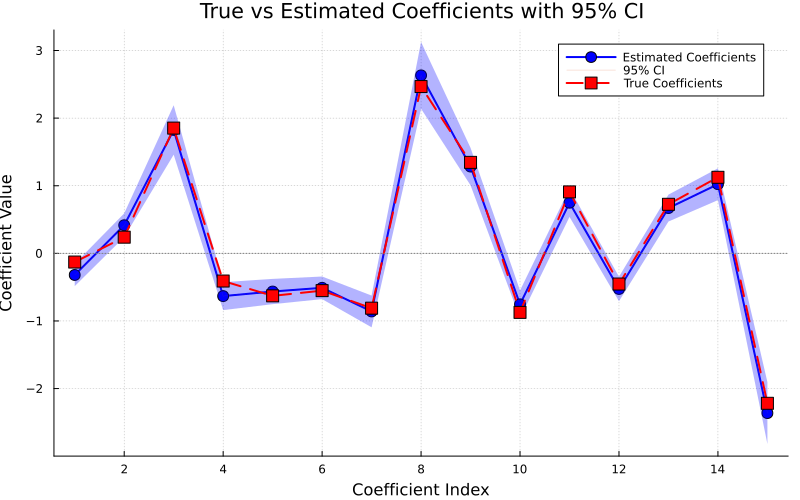


Coefficient Comparison Summary
Index | True Coef | Estimated | Std Error | 95% CI Lower | 95% CI Upper | Diff | Rel. Error %
--------------------------------------------------------------------------------
    1 |   -0.1289 |   -0.3198 |    0.0842 |      -0.4849 |      -0.1547 |  -0.1909 |   148.06%
    2 |    0.2389 |    0.4157 |    0.0895 |       0.2402 |       0.5912 |  +0.1768 |    74.00%
    3 |    1.8527 |    1.8250 |    0.1865 |       1.4595 |       2.1905 |  -0.0277 |     1.50%
    4 |   -0.4096 |   -0.6325 |    0.1055 |      -0.8394 |      -0.4257 |  -0.2230 |    54.44%
    5 |   -0.6290 |   -0.5648 |    0.0953 |      -0.7517 |      -0.3779 |  +0.0642 |    10.21%
    6 |   -0.5517 |   -0.5100 |    0.0854 |      -0.6773 |      -0.3427 |  +0.0417 |     7.57%
    7 |   -0.8114 |   -0.8597 |    0.1198 |      -1.0945 |      -0.6249 |  -0.0483 |     5.95%
    8 |    2.4667 |    2.6324 |    0.2520 |       2.1384 |       3.1264 |  +0.1656 |     6.72%
    9 |    1.3456 |    1.2832 |  

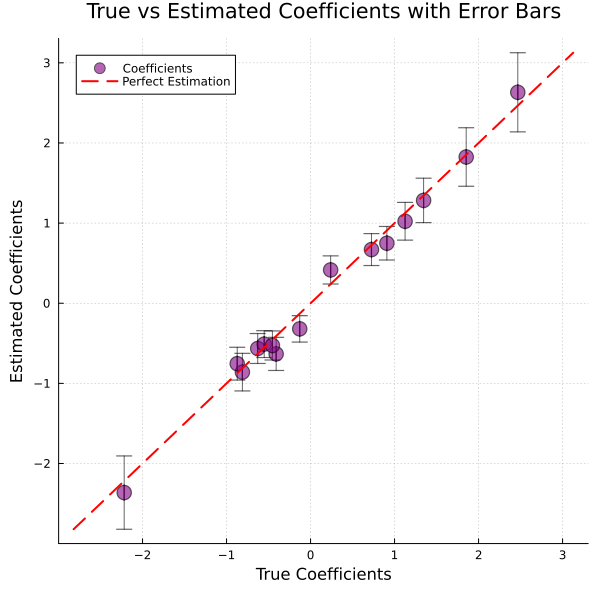

In [63]:
using Plots
using Printf

# Extract estimated coefficients (excluding intercept)
estimated_coefs = model.coef[2:end]  # Skip intercept
n_coefs = length(estimated_coefs)

# Extract standard errors (excluding intercept)
coef_std = model.std_err[2:end]  # Skip intercept std error

# Calculate 95% confidence intervals
ci_lower = estimated_coefs .- 1.96 .* coef_std
ci_upper = estimated_coefs .+ 1.96 .* coef_std

# Create coefficient indices
coef_indices = 1:n_coefs

# Create plot with confidence intervals
p = plot(coef_indices, estimated_coefs, 
         label="Estimated Coefficients",
         marker=:circle, 
         markersize=6,
         linewidth=2,
         color=:blue,
         xlabel="Coefficient Index",
         ylabel="Coefficient Value",
         title="True vs Estimated Coefficients with 95% CI",
         legend=:best,
         size=(800, 500))

# Add confidence interval ribbons
plot!(p, coef_indices, estimated_coefs,
      ribbon=(estimated_coefs .- ci_lower, ci_upper .- estimated_coefs),
      fillalpha=0.3,
      fillcolor=:blue,
      label="95% CI",
      linewidth=0)

# Add true coefficients
plot!(p, coef_indices, true_coeffs,
      label="True Coefficients",
      marker=:square,
      markersize=6,
      linewidth=2,
      color=:red,
      linestyle=:dash)

# Add a horizontal line at y=0 for reference
hline!(p, [0], color=:gray, linestyle=:dot, label="", linewidth=1)

# Add grid for better readability
plot!(p, grid=true, gridstyle=:dot, gridalpha=0.3)

display(p)

# Print comparison statistics
println("\n" * "="^80)
println("Coefficient Comparison Summary")
println("="^80)
println("Index | True Coef | Estimated | Std Error | 95% CI Lower | 95% CI Upper | Diff | Rel. Error %")
println("-"^80)
for i in 1:n_coefs
    diff = estimated_coefs[i] - true_coeffs[i]
    rel_error = abs(diff / true_coeffs[i]) * 100
    @printf("%5d | %9.4f | %9.4f | %9.4f | %12.4f | %12.4f | %+8.4f | %8.2f%%\n",
            i, true_coeffs[i], estimated_coefs[i], coef_std[i], 
            ci_lower[i], ci_upper[i], diff, rel_error)
end
println("="^80)

# Calculate coverage: how many true coefficients fall within CI
coverage = sum((true_coeffs .>= ci_lower) .& (true_coeffs .<= ci_upper))
coverage_rate = coverage / n_coefs * 100
println("\nConfidence Interval Coverage:")
println("  $(coverage) out of $(n_coefs) true coefficients within 95% CI ($(round(coverage_rate, digits=1))%)")

# Calculate overall metrics
mse = mean((estimated_coefs .- true_coeffs).^2)
mae = mean(abs.(estimated_coefs .- true_coeffs))
correlation = cor(true_coeffs, estimated_coefs)

println("\nOverall Performance Metrics:")
println("  Mean Squared Error (MSE):  ", round(mse, digits=6))
println("  Mean Absolute Error (MAE): ", round(mae, digits=6))
println("  Correlation:               ", round(correlation, digits=6))
println("="^80)

# Create a scatter plot comparing true vs estimated with error bars
p2 = scatter(true_coeffs, estimated_coefs,
             xlabel="True Coefficients",
             ylabel="Estimated Coefficients",
             title="True vs Estimated Coefficients with Error Bars",
             label="Coefficients",
             marker=:circle,
             markersize=8,
             color=:purple,
             alpha=0.6,
             size=(600, 600),
             xerror=zeros(n_coefs),  # No error on true values
             yerror=1.96 .* coef_std)  # 95% CI on estimates

# Add diagonal line (perfect estimation)
coef_range = [minimum([true_coeffs; estimated_coefs; ci_lower]), 
              maximum([true_coeffs; estimated_coefs; ci_upper])]
plot!(p2, coef_range, coef_range,
      label="Perfect Estimation",
      color=:red,
      linestyle=:dash,
      linewidth=2)

plot!(p2, grid=true, gridstyle=:dot, gridalpha=0.3)
display(p2)